## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Minimisation des modèles

In [4]:
########################################### Evol Simple

evol1G1M1S = stretchevol.Evol1G1M1S()
evol1G1M1S.set_data(df)

print('1G1M1S')

evol1G1M1S.minimize()
#evol1G1M1S.show_model_tot()

########################################### Evol Kessler

evol1G1M2S = stretchevol.Evol1G1M2S()
evol1G1M2S.set_data(df)

print('1G1M2S')

evol1G1M2S.minimize()
#evol1G1M2S.show_model_tot()

########################################### Evol Howell

evol2G2M2S = stretchevol.Evol2G2M2S()
evol2G2M2S.set_data(df)

print('2G2M2S')

evol2G2M2S.minimize()
#evol2G2M2S.scatter()

########################################### Evol Howell Fixed

evol2G2M2SF = stretchevol.Evol2G2M2SF()
evol2G2M2SF.set_data(df)

print('2G2M2SF')

evol2G2M2SF.minimize()
#evol2G2M2SF.scatter()

########################################### Evol Howell Z

evol2G2M2Sz = stretchevol.Evol2G2M2S()
evol2G2M2Sz.set_data(df, py=False)

print('2G2M2Sz')

evol2G2M2Sz.minimize()
#evol2G2M2S.scatter()

########################################### Evol Howell Fixed Z

evol2G2M2SFz = stretchevol.Evol2G2M2SF()
evol2G2M2SFz.set_data(df, py=False)

print('2G2M2SFz')

evol2G2M2SFz.minimize()
#evol2G2M2SF.scatter()

########################################### Evol NR 2S

evol3G2M2S = stretchevol.Evol3G2M2S()
evol3G2M2S.set_data(df)

print('3G2M2S')

evol3G2M2S.minimize()
#evol3G2M2S.scatter()

########################################### Evol NR 2S z

evol3G2M2Sz = stretchevol.Evol3G2M2S()
evol3G2M2Sz.set_data(df, py=False)

print('3G2M2Sz')

evol3G2M2Sz.minimize()
#evol3G2M2S.scatter()

########################################### Evol NR 2S Fixed

evol3G2M2SF = stretchevol.Evol3G2M2SF()
evol3G2M2SF.set_data(df)

print('3G2M2SF')

evol3G2M2SF.minimize(limit_f = (0,1))
#evol3G2M2SF.scatter()

########################################### Evol NR 2S Fixed Z

evol3G2M2SFz = stretchevol.Evol3G2M2SF()
evol3G2M2SFz.set_data(df, py=False)

print('3G2M2SFz')

evol3G2M2SFz.minimize(limit_f = (0,1))
#evol3G2M2SF.scatter()

########################################### Evol NR 3S

evol3G3M3S = stretchevol.Evol3G3M3S()
evol3G3M3S.set_data(df)

print('3G3M3S')

evol3G3M3S.minimize()

########################################### Evol NR 3S Z

evol3G3M3Sz = stretchevol.Evol3G3M3S()
evol3G3M3Sz.set_data(df, py=False)

print('3G3M3Sz')

evol3G3M3Sz.minimize()

1G1M1S
1G1M2S
2G2M2S
2G2M2SF
2G2M2Sz
2G2M2SFz
3G2M2S
3G2M2Sz
3G2M2SF
3G2M2SFz
3G3M3S
3G3M3Sz


# $\chi^2$ test for Base model

In [5]:
modèles = [evol3G2M2S, evol2G2M2S,
           evol1G1M2S, evol2G2M2SF, evol3G2M2SF,
           evol1G1M1S]

In [6]:
ind = 0
k = modèles[ind]

In [7]:
lnL = -2*np.log(k.likelihood_tot(k.info,
                                 k.stretchs,
                                 k.stretchs_err,
                                 k.param['aa'],
                                 k.param['mu_1'],
                                 k.param['sigma_1'],
                                 k.param['mu_2'],
                                 k.param['sigma_2']))

We can actually check that the sum of the $-2\ln(L)$ list derived this way corresponds to the one in the paper, of simply k.get_logl()

In [11]:
print('-2ln(L) =', np.sum(lnL))

-2ln(L) = 1456.6915735765058


In [8]:
sigma2 = k.stretchs_err**2 + np.mean([k.param['sigma_1']**2, k.param['sigma_2']**2])

Now for the actual list of individual contributions

In [9]:
chi2 = lnL - np.log(2*np.pi*sigma2)

The sum of these should be the same as the global $\chi^2$

In [13]:
print('chi² from sum of individual chi² =', np.sum(chi2))

chi² from sum of individual chi² = 907.0923490836117


In [15]:
print('chi² from the global chi² =', k.get_logl()-np.sum(np.log(2*np.pi*sigma2)))

chi² from the global chi² = 907.0923490836117


## Now plot it

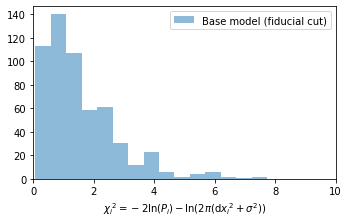

In [12]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])

ax.hist(chi2, bins=15,
        color='C0', alpha=.5,
        label='Base model (fiducial cut)')

ax.set_xlim([0, 10])
ax.set_xlabel(r'$\chi_i{}^2 = -2\ln(P_i) - \ln(2\pi(\mathrm{d}x_i{}^2 + \sigma^2))$')

ax.legend()

fig.savefig('../../Images/pdf/base_chi2-hist.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/base_chi2-hist.png', bbox_inches='tight')

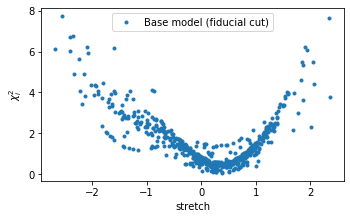

In [13]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])

ax.scatter(k.stretchs, chi2,
           color='C0', marker='.',
           label='Base model (fiducial cut)')

ax.set_xlabel('stretch')
ax.set_ylabel(r'$\chi_i^2$')

ax.legend()

fig.savefig('../../Images/pdf/base_chi2-x1_scatter.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/base_chi2-x1_scatter.png', bbox_inches='tight')

# For per-sample

## Modèles assymSURVEY

In [5]:
gen = stretchevol.generic()
gen.set_model('Evol1G1M2S')

gen.set_data(df[df['survey'] == 'SNF'])
assymSNF = gen.fit()

gen.set_data(df[df['survey'] == 'PS1'])
assymPS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SDSS'])
assymSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
assymSNLS = gen.fit()

gen.set_data(df[df['survey'] == 'HST'])
assymHST = gen.fit()

gen.set_data(df)
assymTOT = gen.fit()

gen.set_data(df[df['survey'].isin(['SDSS','PS1','SNLS','HST'])])
assymTOT_nsnf = gen.fit()

## Modèle BaseTOT

In [6]:
gen.set_model('Evol3G2M2S')

gen.set_data(assymTOT.pd)
baseTOT = gen.fit()

## Table of Per Sample's $-2\ln(L)$

#### These are the results used in the paper

In [7]:
modèles = [assymSNF, assymSDSS, assymPS1, assymSNLS, assymHST]

assym_comp = pd.DataFrame({'Assym': ['SNf', 'SDSS', 'PS1', 'SNLS', 'HST', 'Total'],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles] + [np.sum([len(k.FREEPARAMETERS) for k in modèles])],
                           '$\sigma^-$': [round(k.migrad_out[1][1][2],2) for k in modèles] + ['--'],
                           '$\sigma^-_{\mathrm{err}}$': [round(k.migrad_out[1][1][3],2) for k in modèles] + ['--'],
                           '$\sigma^+$': [round(k.migrad_out[1][2][2],2) for k in modèles] + ['--'],
                           '$\sigma^+_{\mathrm{err}}$': [round(k.migrad_out[1][2][3],2) for k in modèles] + ['--'],
                           '$\mu^0$': [round(k.migrad_out[1][0][2],2) for k in modèles] + ['--'],
                           '$\mu^0_{\mathrm{err}}$': [round(k.migrad_out[1][0][3],2) for k in modèles] + ['--'],
                           '$-2\ln(L)$': [round(k.get_logl()/len(k.stretchs),1) for k in modèles] + [round(np.sum([k.get_logl() for k in modèles]),1)],
                           'AIC': [round(k.get_aic(),1) for k in modèles] + [round(np.sum([k.get_aic() for k in modèles]),1)]})

assym_comp

,Assym,Free param,$\sigma^-$,$\sigma^-_{\mathrm{err}}$,$\sigma^+$,$\sigma^+_{\mathrm{err}}$,$\mu^0$,$\mu^0_{\mathrm{err}}$,$-2\ln(L)$,AIC
0,SNf,3,1.34,0.13,-0.41,0.1,0.68,0.15,2.6,305.3
1,SDSS,3,1.31,0.11,0.42,0.09,0.72,0.13,2.7,451.0
2,PS1,3,1.01,0.11,-0.52,0.12,0.38,0.16,2.5,403.4
3,SNLS,3,1.41,0.13,0.15,0.13,1.22,0.15,2.5,258.7
4,HST,3,0.76,0.36,0.79,0.35,0.11,0.44,2.8,79.7
5,Total,15,--,--,--,--,--,--,1468.2,1498.2


In [21]:
print('Delta AIC w/ BBC-modeling =',
      round(baseTOT.get_aic()-np.sum([k.get_aic() for k in modèles]),1))

Delta AIC w/ BBC-modeling = -31.5


In [22]:
print('Proba w/ BBC-modeling =',
      np.exp((baseTOT.get_aic() - np.sum([k.get_aic() for k in modèles]))/2))

Proba w/ BBC-modeling = 1.4685212637847966e-07


## $\chi^2$ individual contribution determination with sigma contribution

We need to determine the total $\chi^2$ of the 5 samples, each having its own stretchs, errors and bestfit parameters, hence the "for" loop.

In order to add the correct $\sigma_\pm$ to the corresponding $x_{1, \text{err}}$ if the original $x_1$ was below or above the mean in the sigma2 term, I used a mask keeping only the indexes of where the stretch was below the mean. That way, I concatenate the list of errors corresponding to stretchs below $\mu$, and the one corresponding to stretchs above $\mu$.

But to determine the total $\chi^2$, we need to substract this list to the $-2\ln(L)$ one, so their indexes have to correspond to the same SN. That means that we also need to concatenate the list of $-2\ln(L)$ for which the stretchs are below and above, respectively.

Because we ultimately want to plot the scatter of $\chi^2$ vs. $x_1$, the stretch *also* needs to be in the same order, explaining the last line of the "for" loop.

In [23]:
lnL = []
sigma2 = []
stretches = []
for t in modèles:
    mask = t.stretchs < t.param['mu']
    sigma2 += list((t.stretchs_err**2 + t.param['sigma_m']**2)[mask])\
            + list((t.stretchs_err**2 + t.param['sigma_p']**2)[~mask])
    lnL += list(-2*np.log(t.likelihood_tot(t.stretchs[mask],
                                           t.stretchs_err[mask],
                                           t.param['mu'],
                                           t.param['sigma_m'],
                                           t.param['sigma_p'])).values)\
         + list(-2*np.log(t.likelihood_tot(t.stretchs[~mask],
                                           t.stretchs_err[~mask],
                                           t.param['mu'],
                                           t.param['sigma_m'],
                                           t.param['sigma_p'])).values)
    stretches += list((t.stretchs)[mask]) + list((t.stretchs)[~mask])
lnL = np.asarray(lnL)
sigma2 = np.asarray(sigma2)
lg2pisigma2 = np.log(2*np.pi*sigma2)
stretches = np.asarray(stretches)

We can actually check that the sum of the $-2\ln(L)$ list derived this way corresponds to the one we determined earlier

In [32]:
print('-2ln(L) =', np.sum(lnL))

-2ln(L) =  1468.1592529754487


Now for the actual list of individual contributions

In [21]:
chi2 = lnL-lg2pisigma2

The sum of these should be the same as the unordered $\chi^2$

In [33]:
print('chi² from sum of ordered, individual chi² =', np.sum(chi2))

chi² from sum of ordered, individual chi² = 457.55415133087877


In [35]:
print('chi² from the sample-sum, unordered chi² =',
      np.sum([t.get_logl() for t in modèles]) - np.sum(lg2pisigma2))

chi² from the sample-sum, unordered chi² = 457.55415133087877


## Now plot it

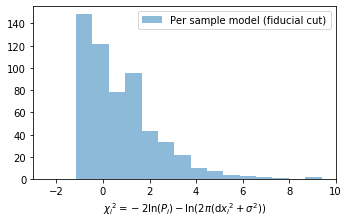

In [23]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])

ax.hist(chi2, bins=15,
        color='C0', alpha=.5,
        label='Per sample model (fiducial cut)')

ax.set_xlim([-3, 10])
ax.set_xlabel(r'$\chi_i{}^2 = -2\ln(P_i) - \ln(2\pi(\mathrm{d}x_i{}^2 + \sigma^2))$')

ax.legend()

fig.savefig('../../Images/pdf/per-samp_chi2-hist.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/per-samp_chi2-hist.png', bbox_inches='tight')

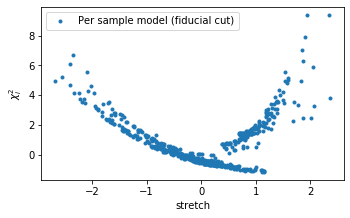

In [25]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])

ax.scatter(stretches, chi2,
           color='C0', marker='.',
           label='Per sample model (fiducial cut)')

ax.set_xlabel('stretch')
ax.set_ylabel(r'$\chi_i^2$')

ax.legend()

fig.savefig('../../Images/pdf/per-samp_chi2-x1_scatter.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/per-samp_chi2-x1_scatter.png', bbox_inches='tight')